In [1]:
# From WoFSCast
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
from wofscast.common.plot_utils import display_name_mapper, units_mapper, get_colormap_and_levels


import matplotlib.pyplot as plt 
import xarray as xr 
import numpy as np

# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


def ns_to_mins(time):
    return time / 1e9 / 60


## Plotting Options 

In [52]:
# TODO: Make this part for robust; we could make a typo or switch names without knowing! 
paths = [
         #'/work2/mflora/verification_datasets/wofscast_test_v178_results.nc', 
         #'/work2/mflora/verification_datasets/wofscast_test_v178_diffusion_results.nc',
          '/work2/mflora/verification_datasets/wofscast_test_v203_results_v2.nc',
         # '/work2/mflora/verification_datasets/wofscast_test_v203_results_v3.nc', # With 40 dbz threshold!
         #'/work2/mflora/verification_datasets/wofscast_test_v178_results_v1.nc'
         #'/work2/mflora/verification_datasets/wofscast_test_v178_results_v2.nc'
        ]
datasets = [xr.load_dataset(path) for path in paths]
dataset_names = [ 
    #'WoFSCast', 
    #'WoFSCastDiff'
    'WoFSCast203'
]

# Plots below can really only handle plotting a single model's results, 
# so use this idx to help with that! 
idx = 0 

times = ns_to_mins(datasets[0].time.values)


rmse_variables = ['T', 'QVAPOR', 'T2', 
                  'U', 'V', 'W',
                  'GEOPOT', 'RAIN_AMOUNT', 'COMPOSITE_REFL_10CM'
                 ]

# Create a list of colors for each line
colors = ['blue', 'green', 'red', 'lightblue', 'magenta', 'gray', 'black', 'orange', 'purple']
line_styles = ['-', 'dashed', '-', '-']

metrics_colors_dict = {'pod' : 'xkcd:tomato red', 
                'sr' : 'xkcd:deep blue',
                'csi': 'k', 
                'fb' : 'purple'
          }

import string
lowercase_letters = list(string.ascii_lowercase)

## Time Series of Root-Mean-Squared-Error 

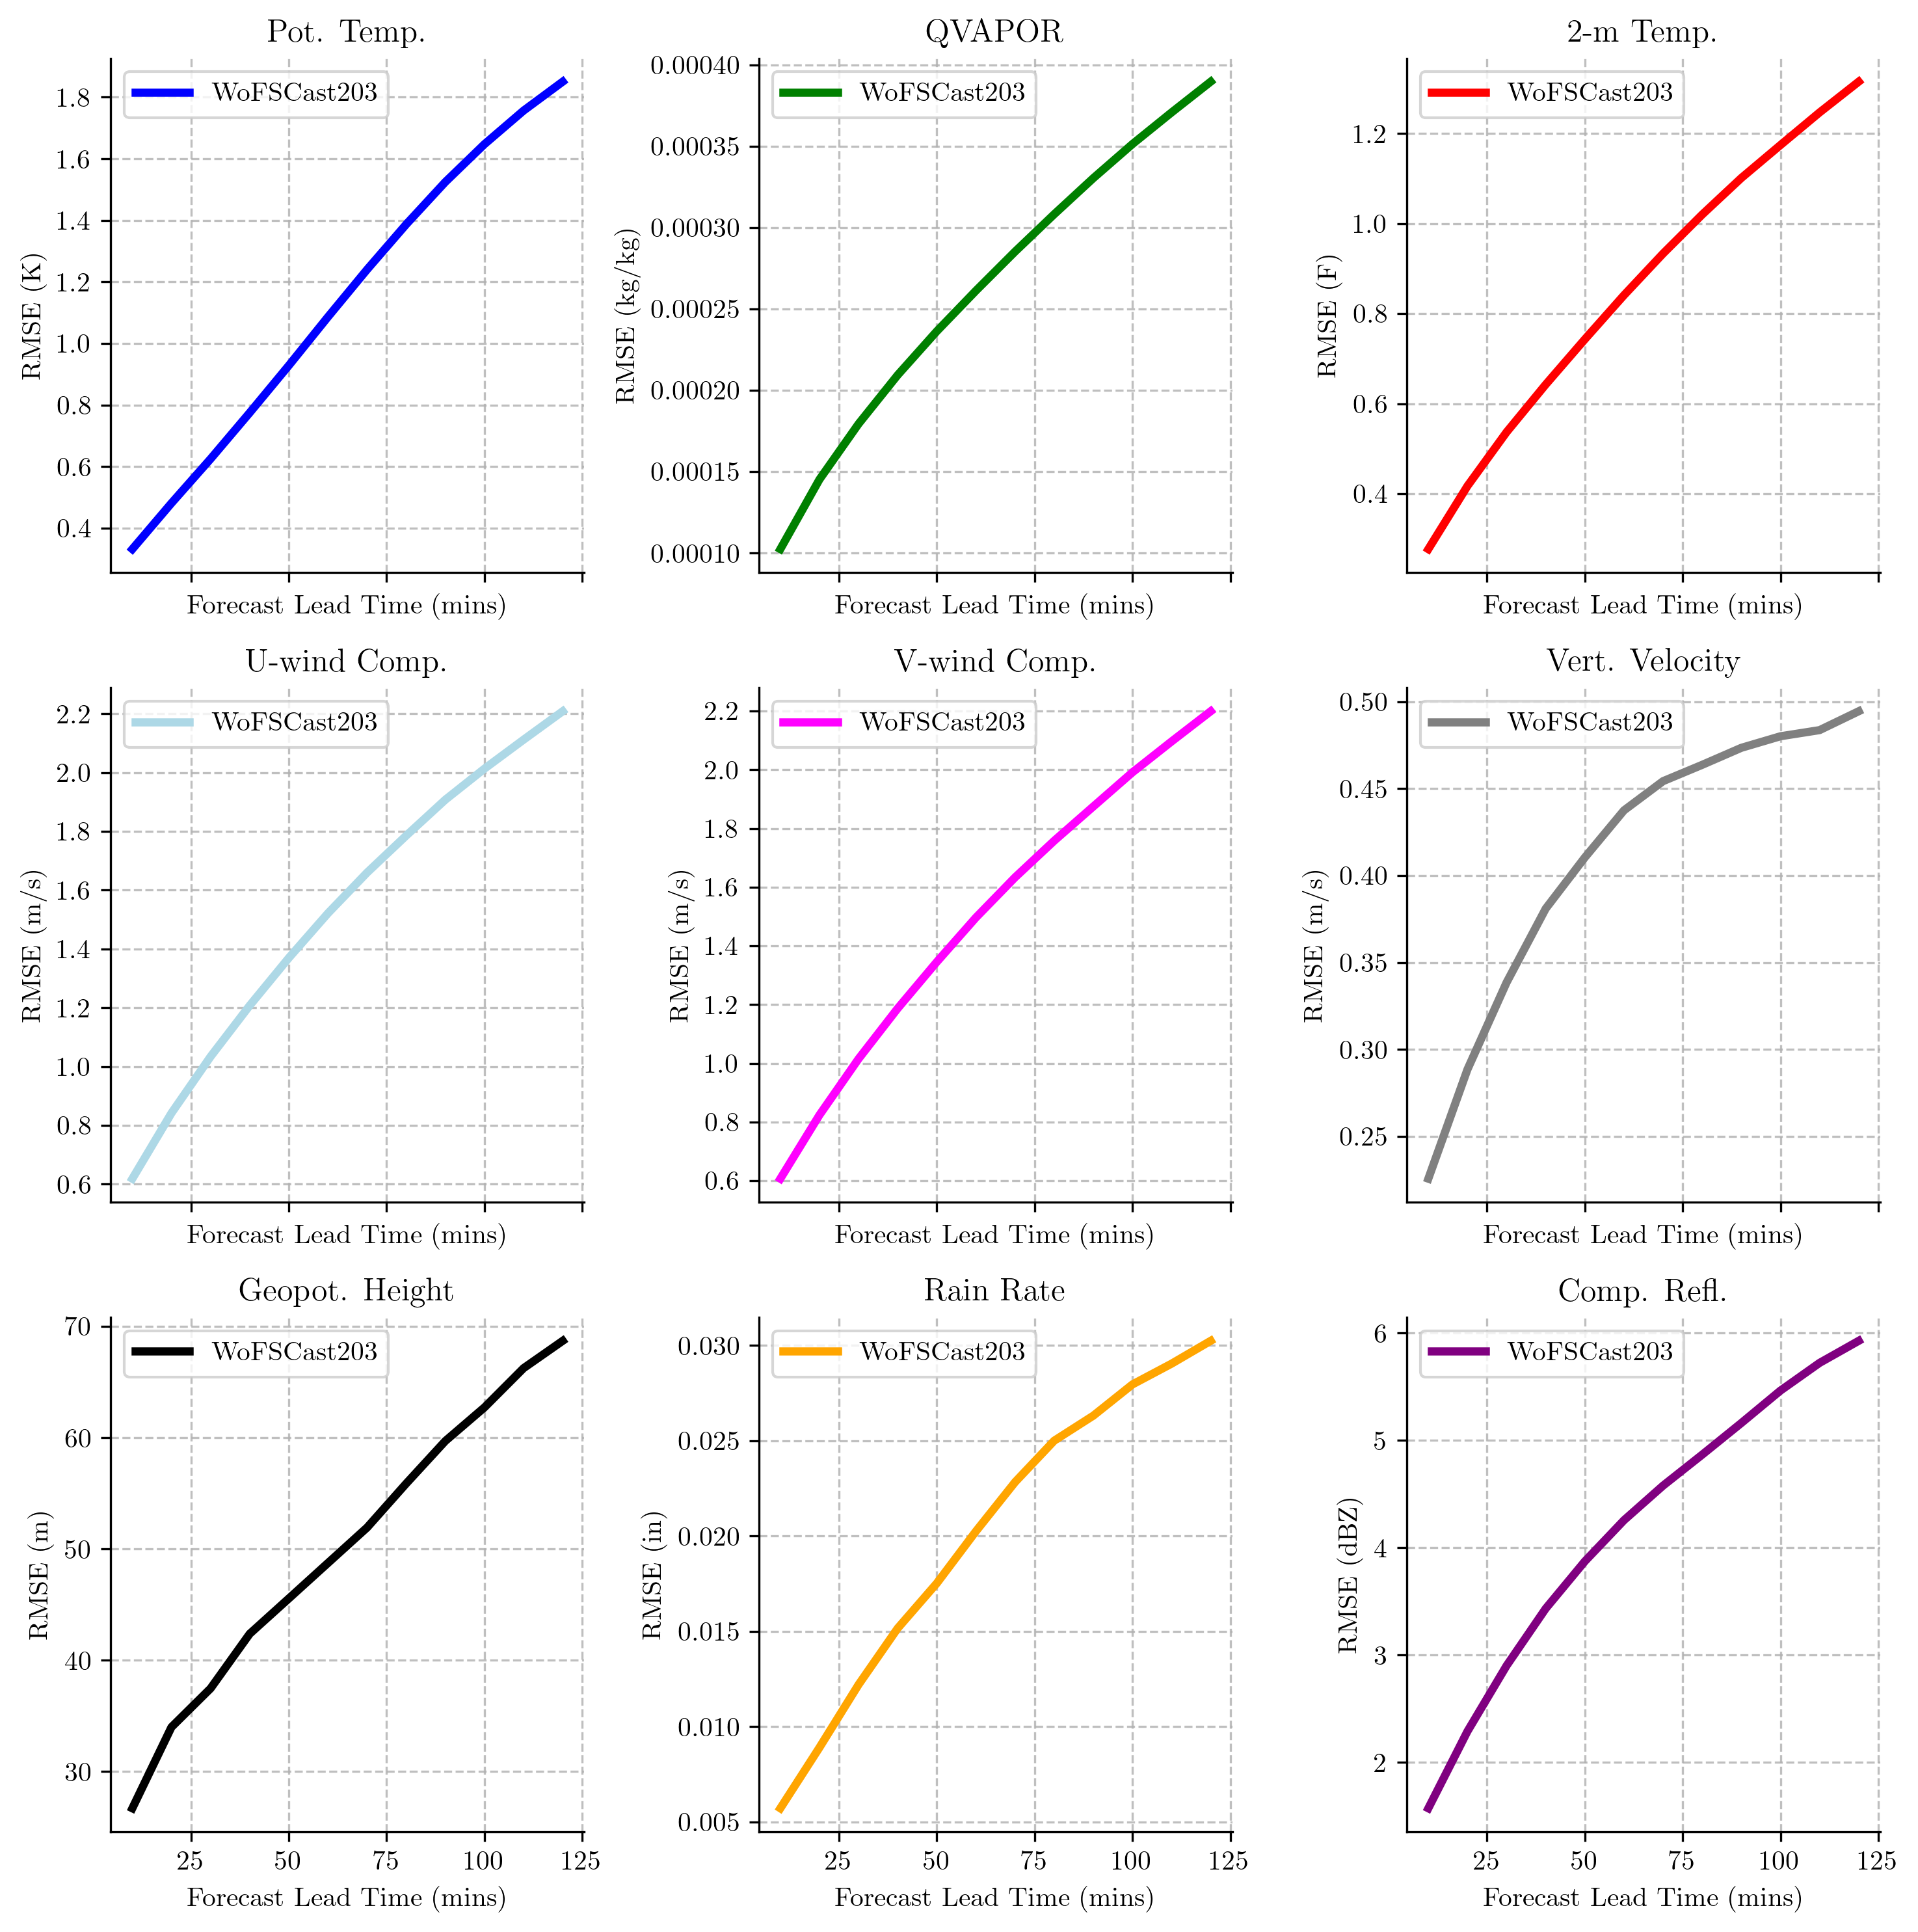

In [53]:
fig, axes = plt.subplots(figsize=(10,10), dpi=300, ncols=3, nrows=3, sharex=True)

for i, (v, ax) in enumerate(zip(rmse_variables, axes.flat)):
    for k, ds in enumerate(datasets):
        ax.plot(times, ds[f'{v}_rmse'], 
                color=colors[i], lw=3.0, label=dataset_names[k],
                ls=line_styles[k])
        
    ax.legend()
    ax.set(xlabel= 'Forecast Lead Time (mins)', 
           ylabel= f"RMSE ({units_mapper.get(v,'')})", 
           title = display_name_mapper.get(v,v),
          )
    ax.grid(ls='dashed', alpha=0.8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
plt.tight_layout()

## WoFSCast vs. WoFS Composite Refl. Object Matching. 

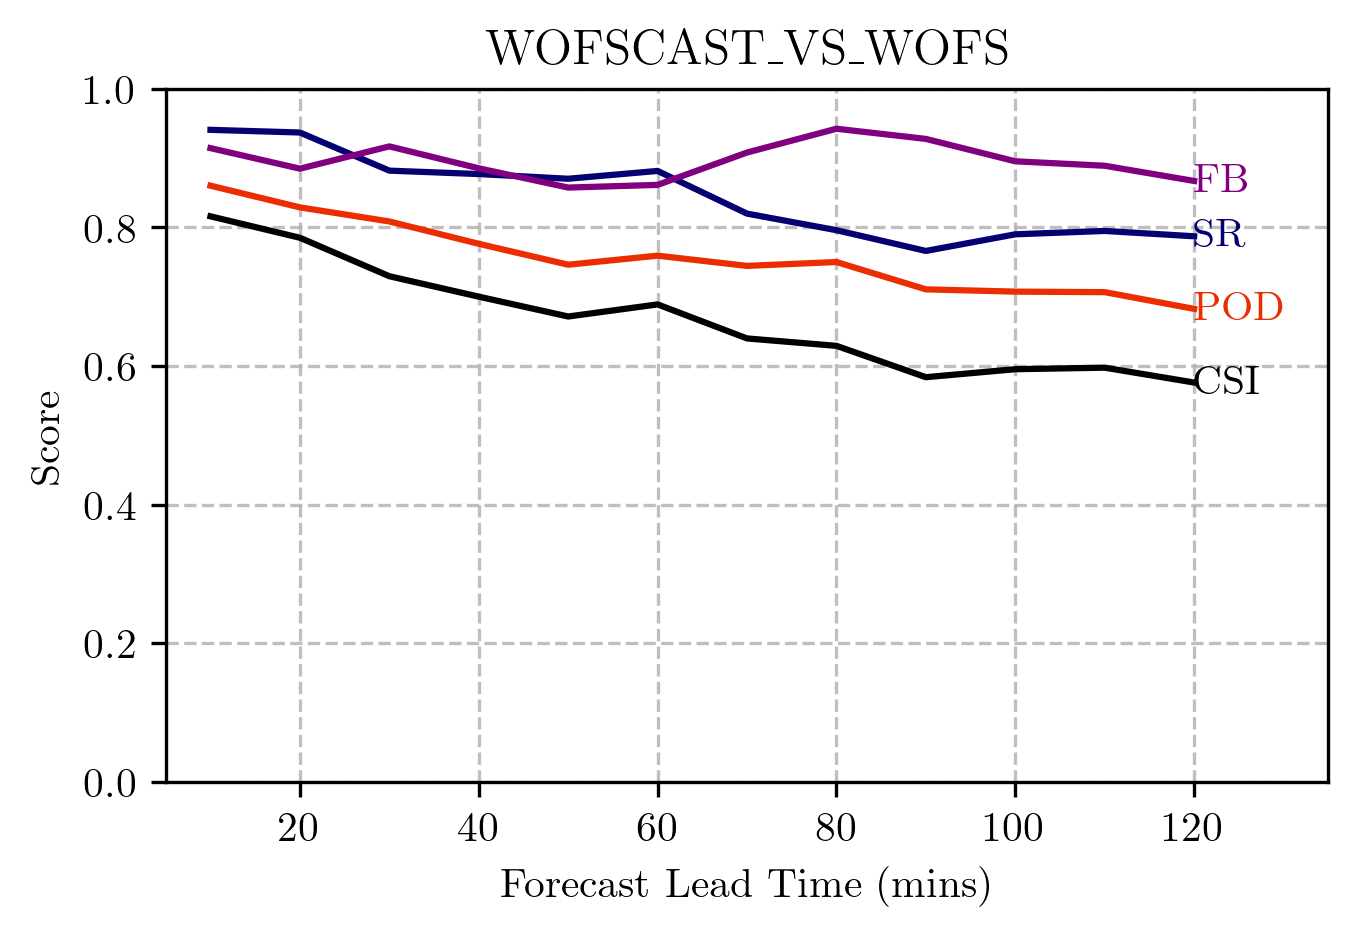

In [54]:
fig, ax = plt.subplots(figsize=(5,3), dpi=300)
key = 'wofscast_vs_wofs'
metrics = ['pod', 'sr', 'csi', 'fb']

ax.set(ylim=[0,1.0],
       xlim=[5,135],
       xlabel = 'Forecast Lead Time (mins)', 
       ylabel = 'Score',
       title = key.upper()
      )

for metric in metrics:
    for k, ds in enumerate(datasets):
        ax.plot(times, ds[f'{key}_{metric}'], color=metrics_colors_dict[metric], 
                label=dataset_names[k], ls=line_styles[k])
        ax.grid(ls='dashed', alpha=0.8)
        # Add the labels next to the lines
        if k==0:
            ax.text(times[-1], ds[f'{key}_{metric}'][-1], metric.upper(), color=metrics_colors_dict[metric],
                fontsize=10, va='center')

#ax.legend(loc='lower left')

## WoFSCast, WoFS, and MRMS 

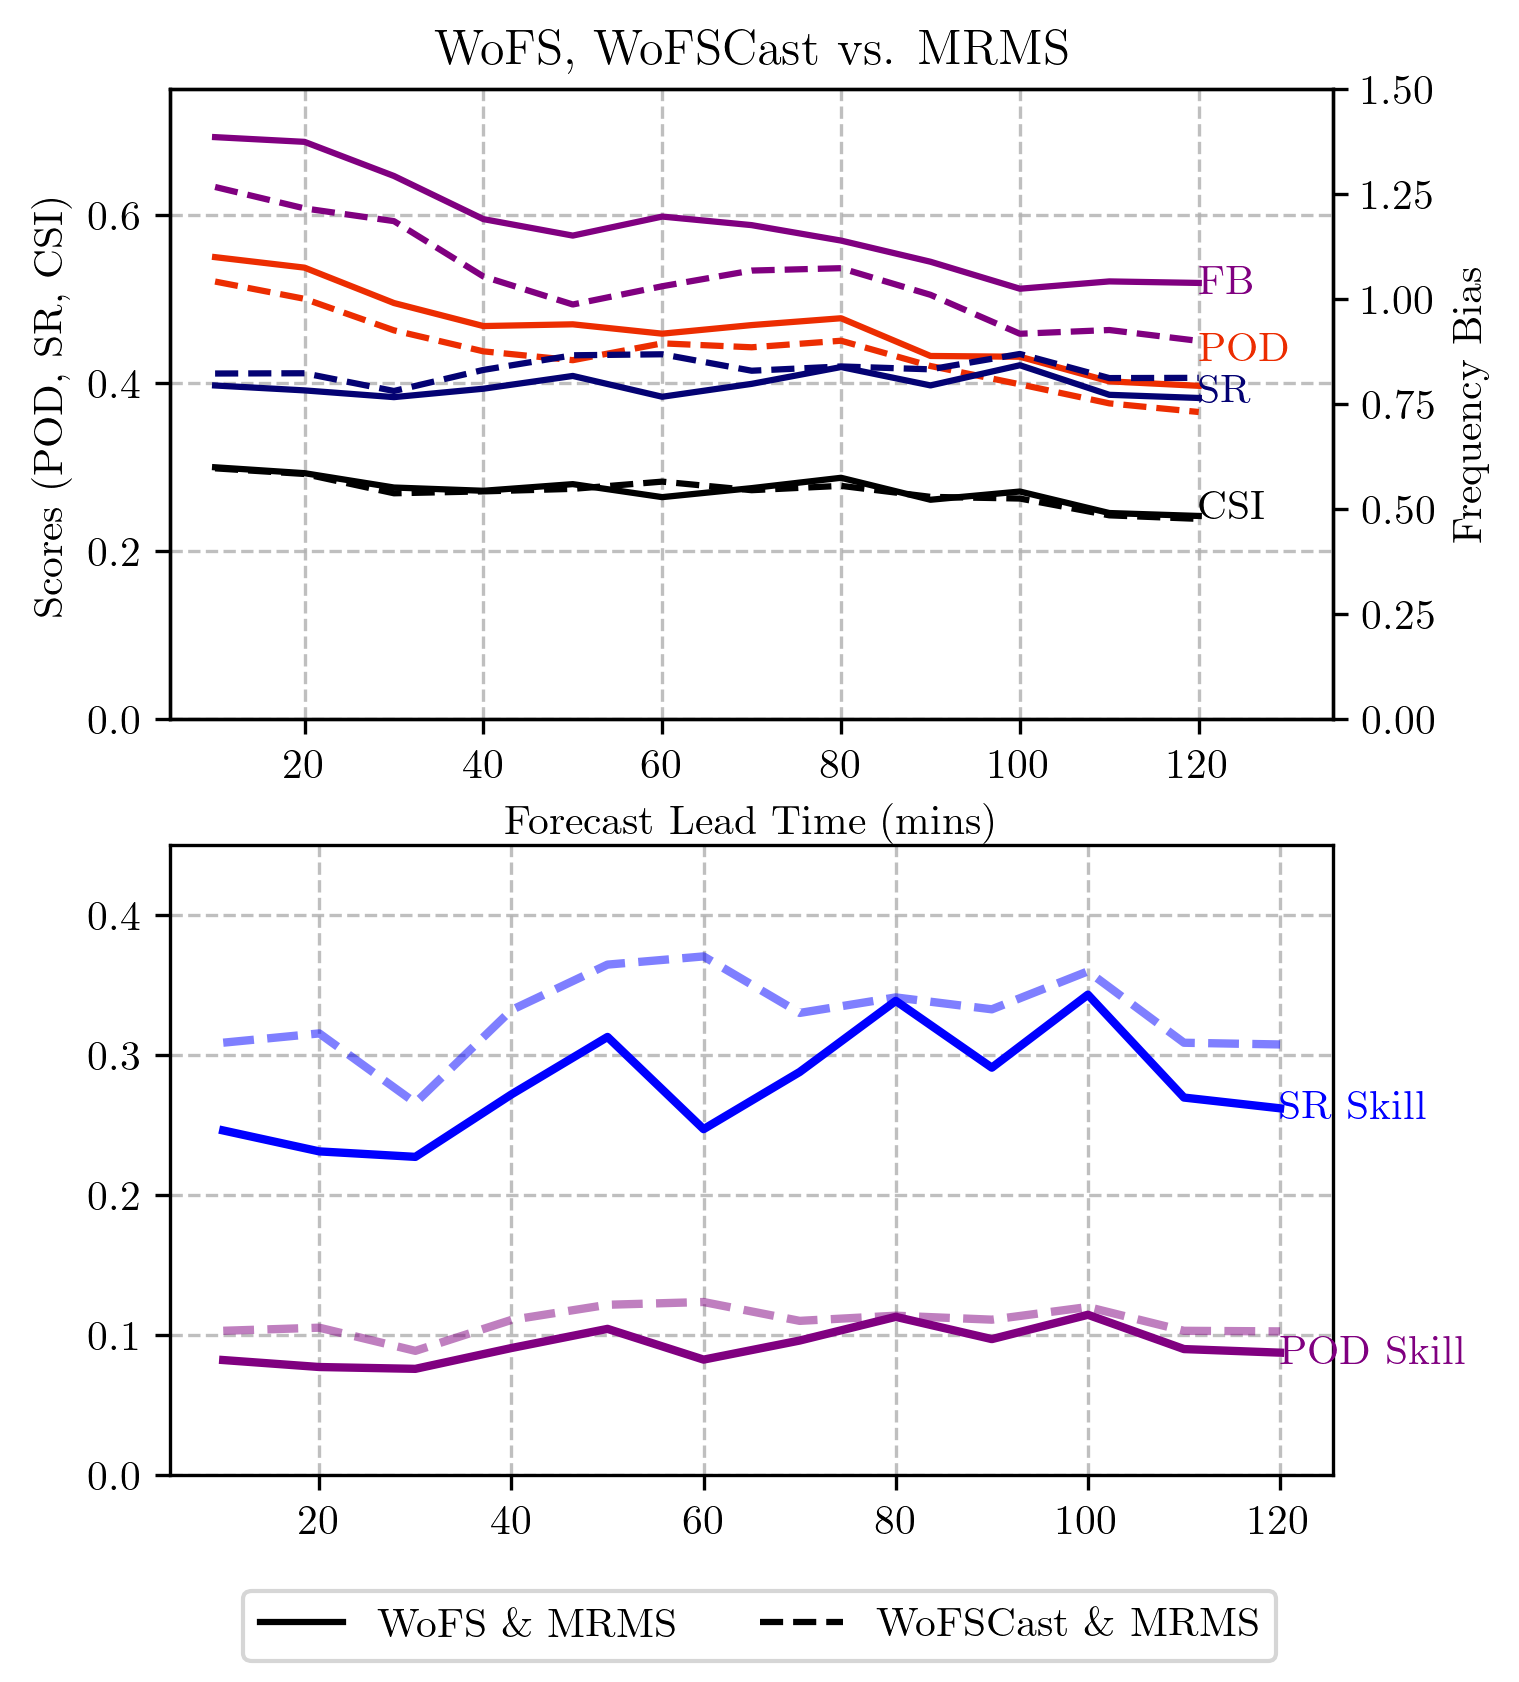

In [60]:
import random 
import matplotlib.lines as mlines

fig, axes = plt.subplots(figsize=(5,6), dpi=300, nrows=2)
keys = ['wofs_vs_mrms', 'wofscast_vs_mrms']
labels = ['WoFS', 'WoFSCast']

metrics = ['pod', 'sr', 'csi']

ax = axes[0]

ax.set(
       ylim=[0, 0.75],
       xlim=[5,135],
       xlabel = 'Forecast Lead Time (mins)', 
       ylabel = 'Scores (POD, SR, CSI)',
       title = 'WoFS, WoFSCast vs. MRMS',
      )

# POD, SR, CSI 
for metric in metrics:
    for k, key in enumerate(keys):
        noise = random.uniform(0, 0.05)
        ax.plot(times, ds[f'{key}_{metric}'], color=metrics_colors_dict[metric], 
                label=labels[k], ls=line_styles[k])
        ax.grid(ls='dashed', alpha=0.8)
        # Add the labels next to the lines
        if k==0:
            ax.text(times[-1], ds[f'{key}_{metric}'][-1]+noise, metric.upper(), color=metrics_colors_dict[metric],
                fontsize=10, va='center')

ax_twinx = ax.twinx()
ax_twinx.set(ylim=[0, 1.5], ylabel='Frequency Bias')
metric = 'fb'
for k, key in enumerate(keys):
    ax_twinx.plot(times, ds[f'{key}_{metric}'], color=metrics_colors_dict[metric], 
                label=labels[k], ls=line_styles[k])
    # Add the labels next to the lines
    if k==0:
            ax_twinx.text(times[-1], ds[f'{key}_{metric}'][-1], metric.upper(), 
                          color=metrics_colors_dict[metric],
                fontsize=10, va='center')
            
# POD - SR Skill lines 
ax = axes[1]
ax.grid(ls='dashed', alpha=0.8)
ax.set(ylim=[0, 0.45])

# Using the formulas from Brooks 2004 paper on signal theory 
# a+b+c+d = 1.0 
# f = a + c (assumed base rate)
# a = f*POD
# b = a*(FAR/SR)

f = 0.25 # Assumed base rate!!
x_bar = 0.5 # Assumed predicted frequency


lw = 2.0 # Line width 

for i, key in enumerate(keys):
    pod = ds[f'{key}_pod'].values
    sr = ds[f'{key}_sr'].values
    far = 1.0-sr
    
    a = f*pod 
    b = a*(far/sr)
    d = 1-f-b
    c = 1-f-d
    
    # POD Skill = (ad-bc) / (x_bar * (1-f))
    # SR Skill = (ad-bc) / (f * (1-x_bar))
    
    pod_skill = (a*d-b*c) / (x_bar * (1.0-f))
    sr_skill = (a*d-b*c) / (f * (1.0-x_bar))
    
    line, = ax.plot(times, pod_skill, c='purple', label='POD Skill', ls=line_styles[i], 
                       lw=lw, alpha=1.0-(i*0.5))
    line, = ax.plot(times, sr_skill, c='blue', label='POD Skill', ls=line_styles[i], 
                       lw=lw, alpha=1.0-(i*0.5))

    # Add the labels next to the lines
    if i==0:
        ax.text(times[-1], pod_skill[-1], 'POD Skill', color='purple', 
            fontsize=10, va='center')
        ax.text(times[-1], sr_skill[-1], 'SR Skill', color='blue', 
            fontsize=10, va='center')
            
# Create custom legend handles (lines)
solid_line = mlines.Line2D([], [], color='black', linestyle='-', label="WoFS \& MRMS")
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label="WoFSCast \& MRMS")
# Add the legend
fig.legend(handles=[solid_line, dashed_line], loc='lower center', ncol=2)

## Power Spectra 

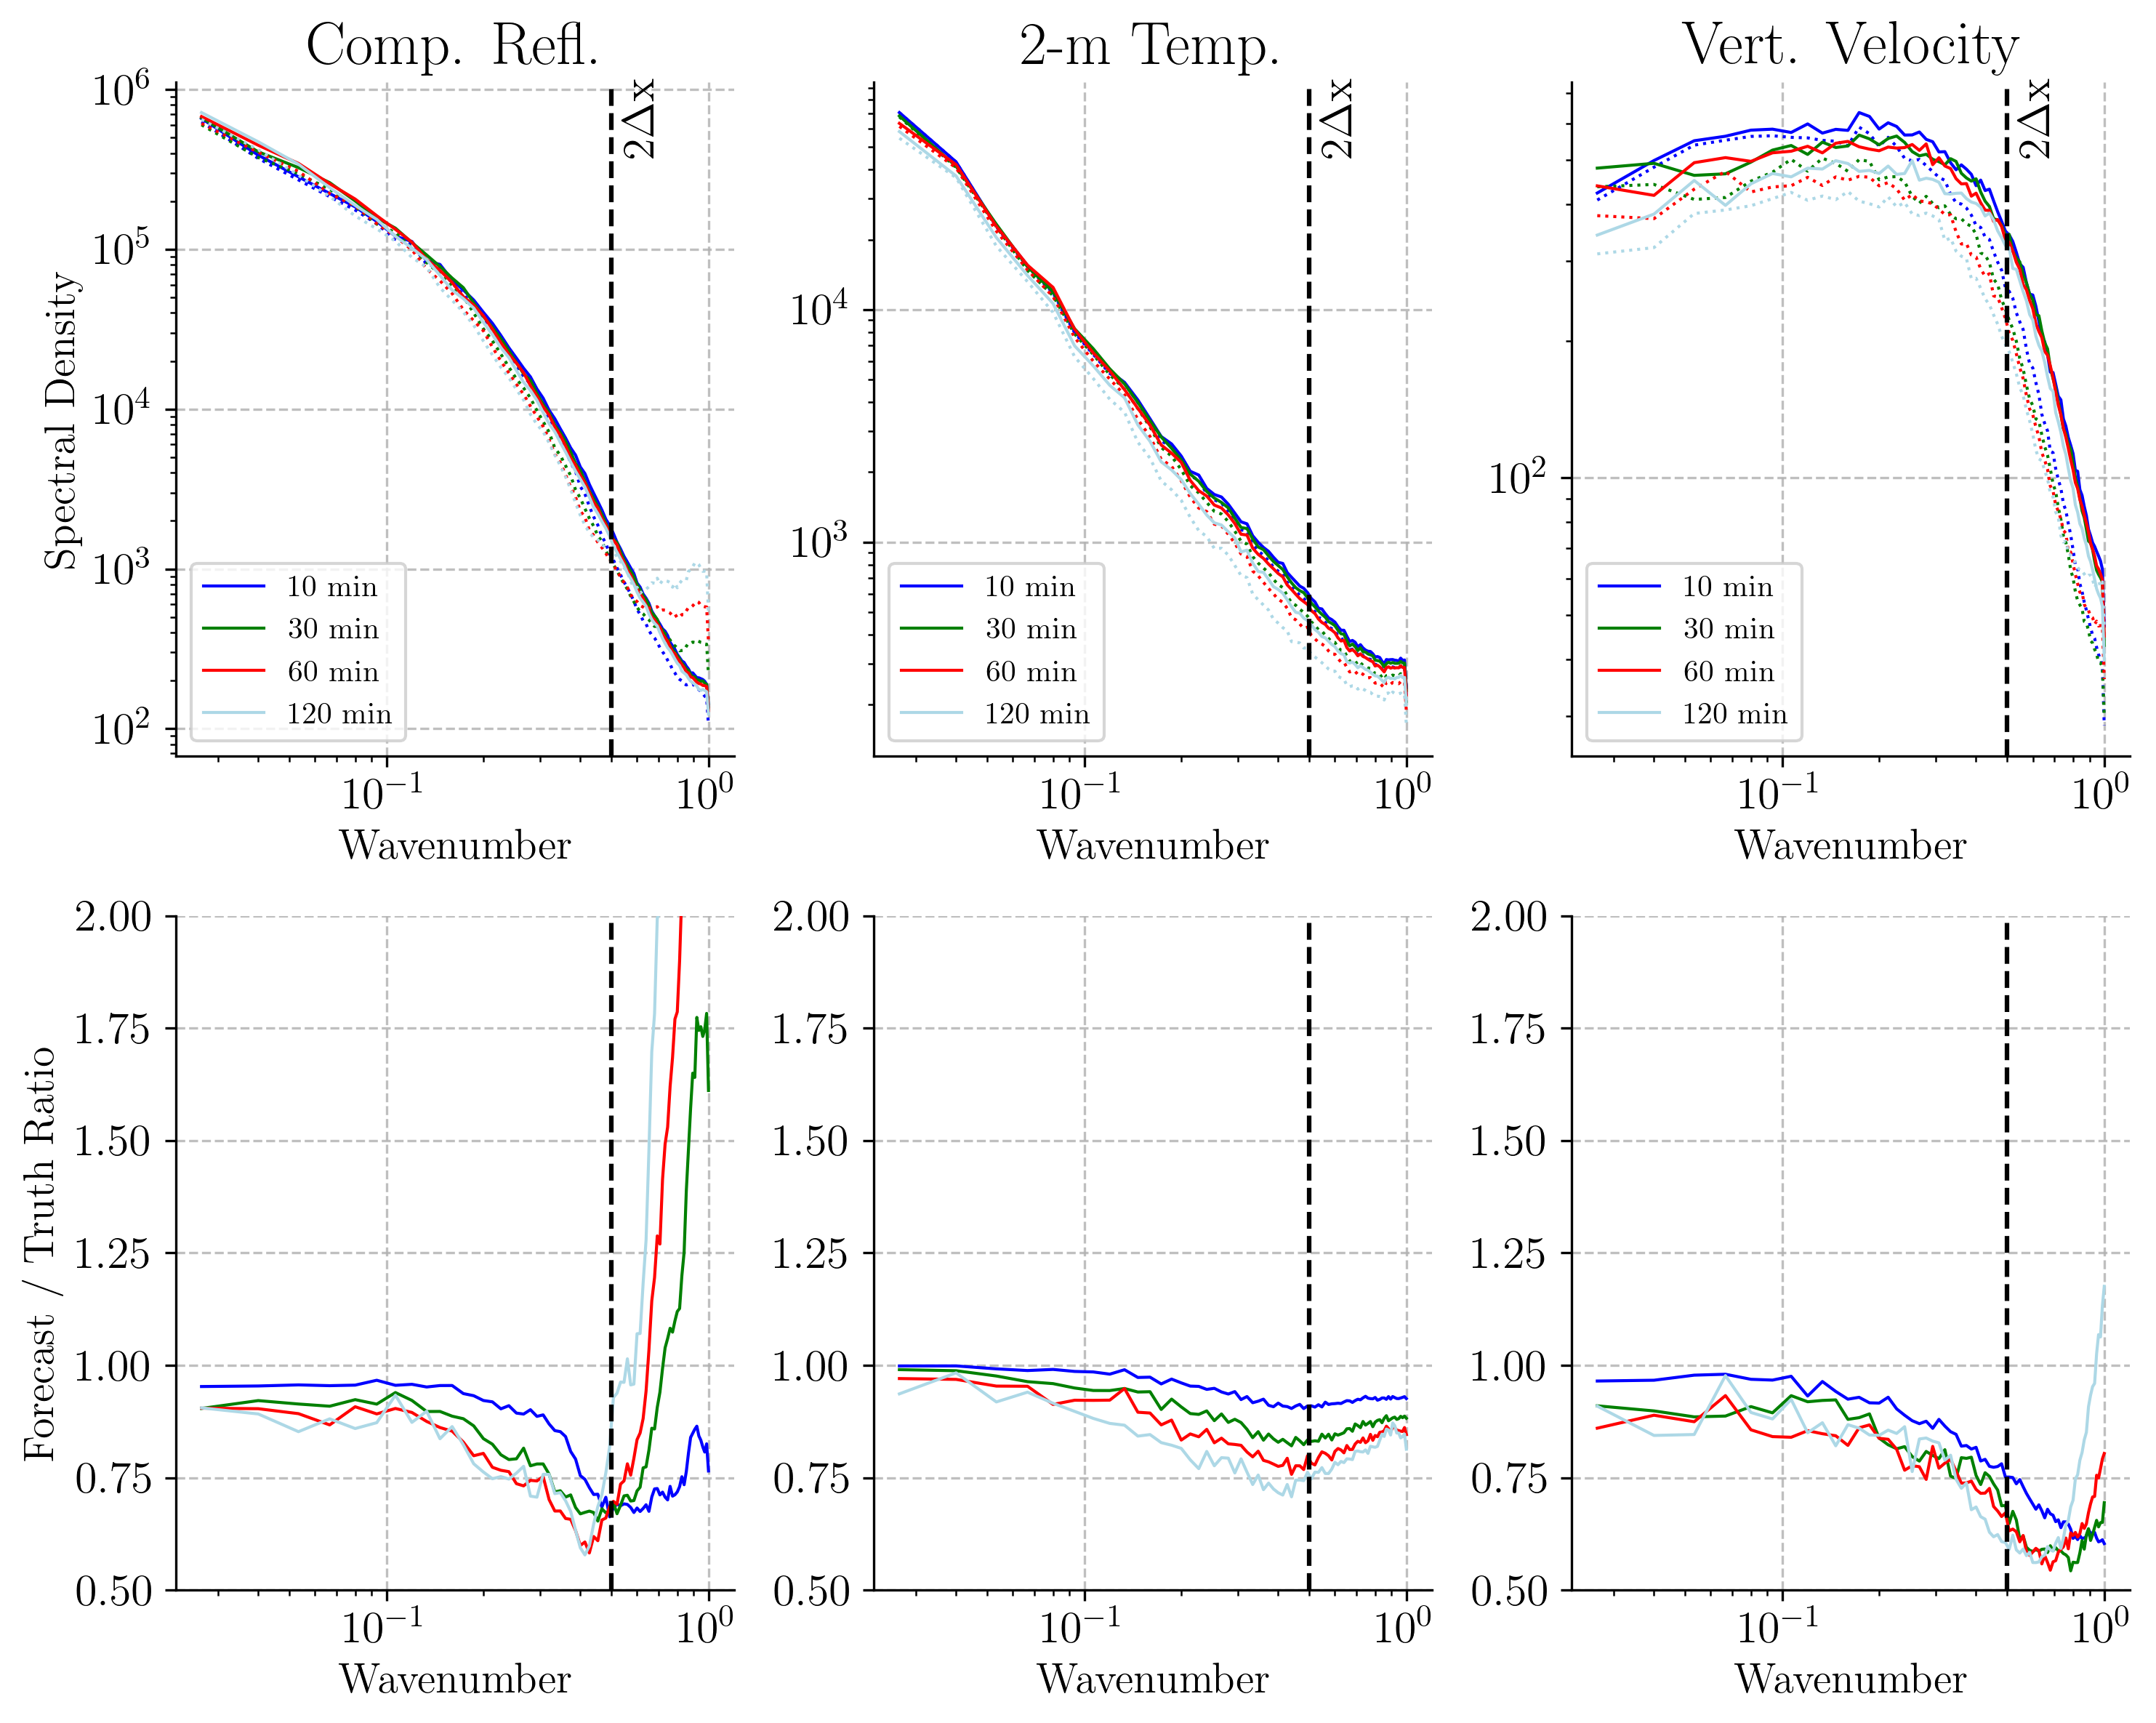

In [22]:
fig, axes = plt.subplots(figsize=(10,8), dpi=300, ncols=3, nrows=2, sharey=False)

# Create a list of colors for each line
colors = ['blue', 'green', 'red', 'lightblue', 'magenta', 'gray', 'black', 'orange', 'purple']
desired_times = [10, 30, 60, 120]
time_indices = [i for i, time in enumerate(times) if time in desired_times]

spectra_variables = ['COMPOSITE_REFL_10CM', 'T2', 'W']


# Top 3 Panels: Power Spectra plotted for the forecast 
#               and target variables at different lead times.
for i, (v, ax,) in enumerate(zip(spectra_variables, axes.flat[:3])):       
    for n, t in enumerate(time_indices):
        ax.loglog(datasets[idx].wave_num[1:], 
                  datasets[idx][f'{v}_forecast_spectra'].isel(time=t)[1:], c=colors[n], lw=1, ls=':') 
        ax.loglog(datasets[idx].wave_num[1:], 
                  datasets[idx][f'{v}_truth_spectra'].isel(time=t)[1:], c=colors[n], 
                  lw=1, label=f'{desired_times[n]} min') 
    ax.legend(loc='lower left')
    
    ylabel = r"Spectral Density" if i==0 else ""
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(r"Wavenumber", fontsize=14)
    ax.set_title(display_name_mapper.get(v,v), fontsize=20)
    ax.grid(ls='dashed', alpha=0.8)
    ax.axvline(x=0.5, linestyle='--', color='k', lw=1.5) 
    ax.annotate('2$\Delta$x', xy=(0.8, 0.9), xycoords='axes fraction', rotation=90, fontsize=15)
    
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Increase tick font size
    ax.tick_params(axis='both', which='major', labelsize=15)  # Increase font size of tick labels

    
# Bottom 3 Panels: Ratio of forecast to target spectra
for i, (v, ax) in enumerate(zip(spectra_variables, axes.flat[3:])):
    for n, t in enumerate(time_indices):
        forecast_spectra = datasets[idx][f'{v}_forecast_spectra'].isel(time=t)[1:]
        truth_spectra = datasets[idx][f'{v}_truth_spectra'].isel(time=t)[1:]
        ratio = forecast_spectra / truth_spectra
        
        ax.plot(datasets[idx].wave_num[1:], ratio, c=colors[n], lw=1, label=f'{desired_times[n]} min')
    
    # Set x-axis to logarithmic scale
    ax.set_xscale('log')
    
    ylabel = r"Forecast / Truth Ratio" if i == 0 else ""
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(r"Wavenumber", fontsize=14)
    ax.grid(ls='dashed', alpha=0.8)
    ax.axvline(x=0.5, linestyle='--', color='k', lw=1.5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_ylim([0.5, 2.0])
    
plt.tight_layout()

## Probability Matched Mean Storm Structure Assessment 

/tmp/ipykernel_415309/1333528615.py:50: UserWarning: The following kwargs were not used by contour: 'aspect'
  im3 = axs[2].contourf(difference, origin='lower', aspect='equal',


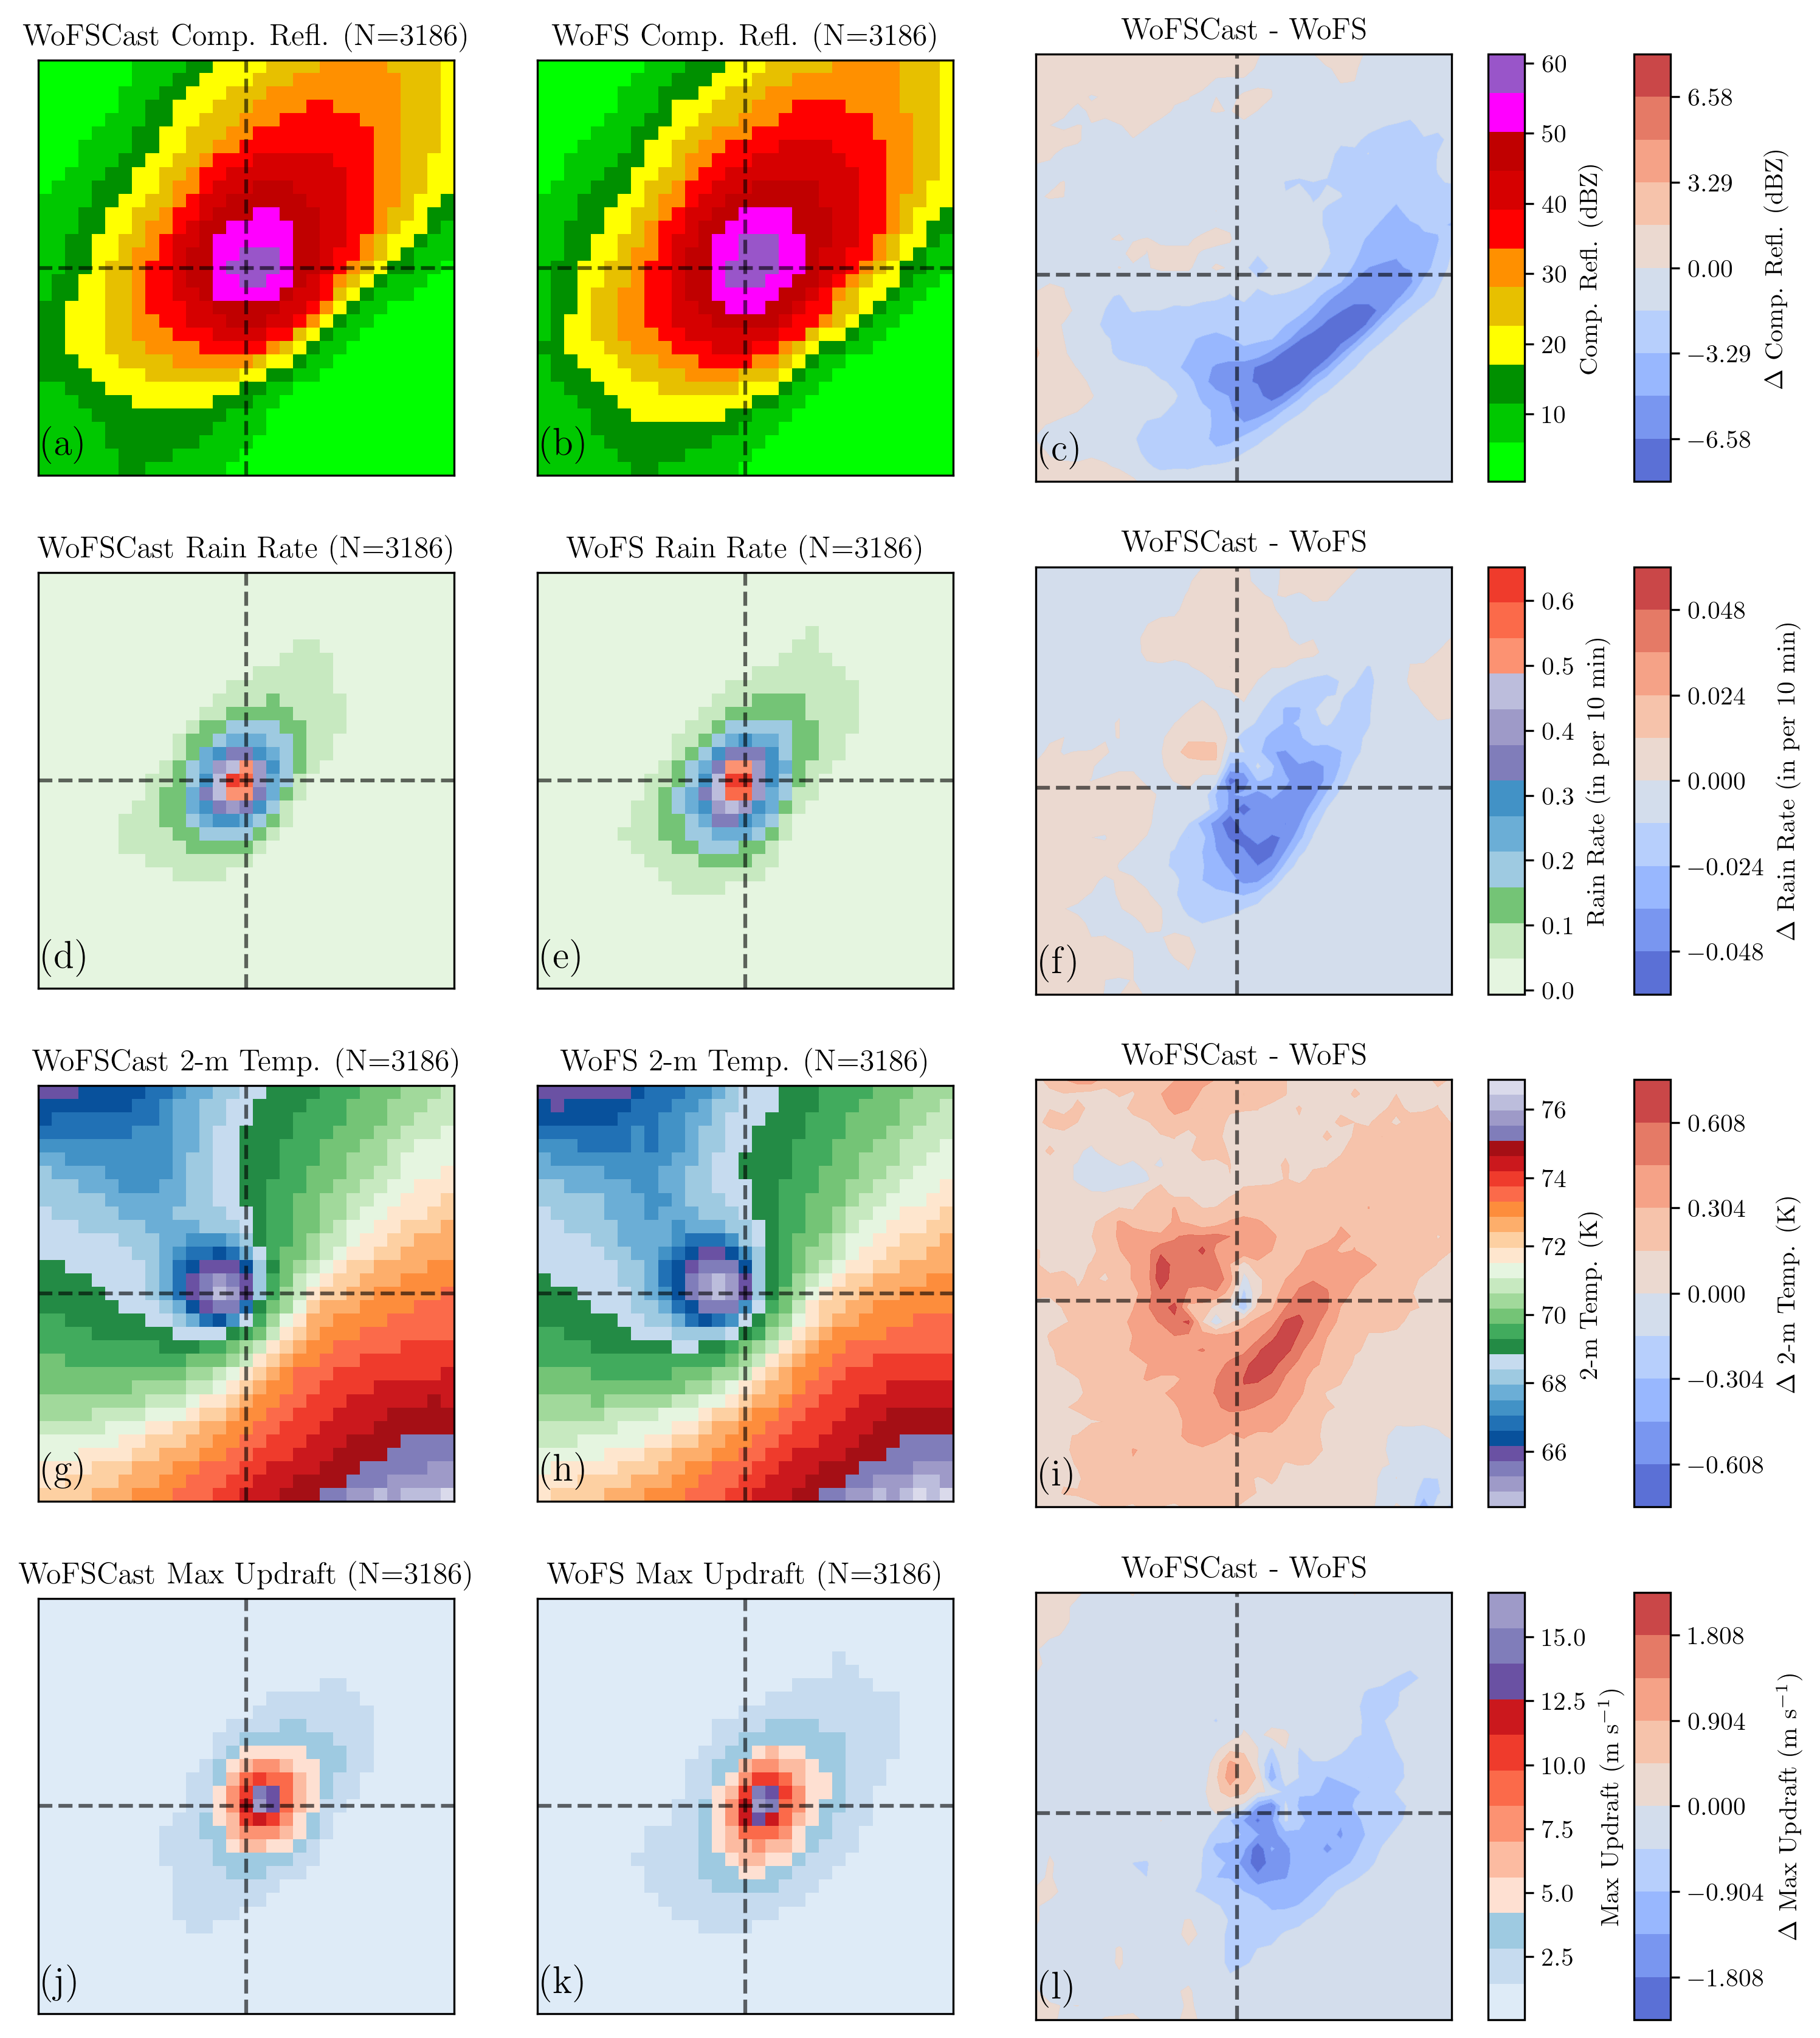

In [7]:
pmm_variables = ['COMPOSITE_REFL_10CM', 'RAIN_AMOUNT', 'T2', 'WMAX']

labels_dict = {'COMPOSITE_REFL_10CM' : 'Comp. Refl.', 
               'RAIN_AMOUNT' : 'Rain Rate',
               'T2' : '2-m Temp.',
               'WMAX' : 'Max Updraft'
              }

units_dict = {'COMPOSITE_REFL_10CM' : 'dBZ', 
               'RAIN_AMOUNT' : 'in per 10 min',
               'T2' : 'K',
               'WMAX' : 'm s$^{-1}$'
              }

fig, axes = plt.subplots(nrows=len(pmm_variables), ncols=3, figsize=(10, 14), dpi=300)

N = datasets[0].attrs['n_pmm_storms']

for i, (axs, v) in enumerate(zip(axes, pmm_variables)):
    cmap, levels = get_colormap_and_levels(v)
    
    forecast_pmm = datasets[idx][f'{v}_forecast_pmm'].values
    truth_pmm = datasets[idx][f'{v}_truth_pmm'].values

    # Combine both forecast and truth PMM values, then find the min and max
    combined_values = np.concatenate([forecast_pmm, truth_pmm])

    vmin = np.min(combined_values)
    vmax = np.max(combined_values)
    
    # Plot the first column (WoFSCast PMM)
    im1 = axs[0].imshow(forecast_pmm, origin='lower', 
                        aspect='equal', cmap=cmap, vmin=vmin, vmax=vmax,)
    
    axs[0].set_title(f'WoFSCast {labels_dict[v]} (N={N})', fontweight='bold')
    
    # Plot the second column (WoFS PMM)
    im2 = axs[1].imshow(truth_pmm, origin='lower', aspect='equal', cmap=cmap, 
                          #levels=levels,
                          vmin=vmin, vmax=vmax,
                         )
    axs[1].set_title(f'WoFS {labels_dict[v]} (N={N})', fontweight='bold')
    
    # WoFSCast - WoFS 
    difference = forecast_pmm  - truth_pmm
    vmax = np.round(np.max(np.abs(difference)) * 1.05, 2)
    vmin = -vmax
    
    # Plot the third column (Difference)
    im3 = axs[2].contourf(difference, origin='lower', aspect='equal', 
                          cmap='coolwarm', alpha=0.9, levels=np.linspace(vmin, vmax, 11))
    axs[2].set_title('WoFSCast - WoFS', fontweight='bold')

    # Create a colorbar axis on the right side of the third panel
    cbar_ax = fig.add_axes([axs[2].get_position().x1 + 0.02, 
                            axs[2].get_position().y0, 
                            0.02, 
                            axs[2].get_position().height])
    cbar = fig.colorbar(im2, cax=cbar_ax, orientation='vertical')
    cbar.ax.set_ylabel(f'{labels_dict[v]} ({units_dict[v]})')
    
    
    # Create a colorbar axis on the right side of the third panel
    cbar_ax = fig.add_axes([axs[2].get_position().x1 + 0.1, 
                            axs[2].get_position().y0, 
                            0.02, 
                            axs[2].get_position().height])
    cbar = fig.colorbar(im3, cax=cbar_ax, orientation='vertical')
    cbar.ax.set_ylabel(f'$\Delta$ {labels_dict[v]} ({units_dict[v]})')
    
    
for i, ax in enumerate(axes.flat):
    #ax.grid(ls='dashed', alpha=0.6)
    # Turn off tick marks for both axes
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.annotate(f'({lowercase_letters[i]})', xy=(0.01, 0.05), xycoords='axes fraction', fontsize=15)
    ax.axvline(x=15, color='k', ls='dashed', alpha=0.6)
    ax.axhline(y=15, color='k', ls='dashed', alpha=0.6)

## Fractions Skill Score 

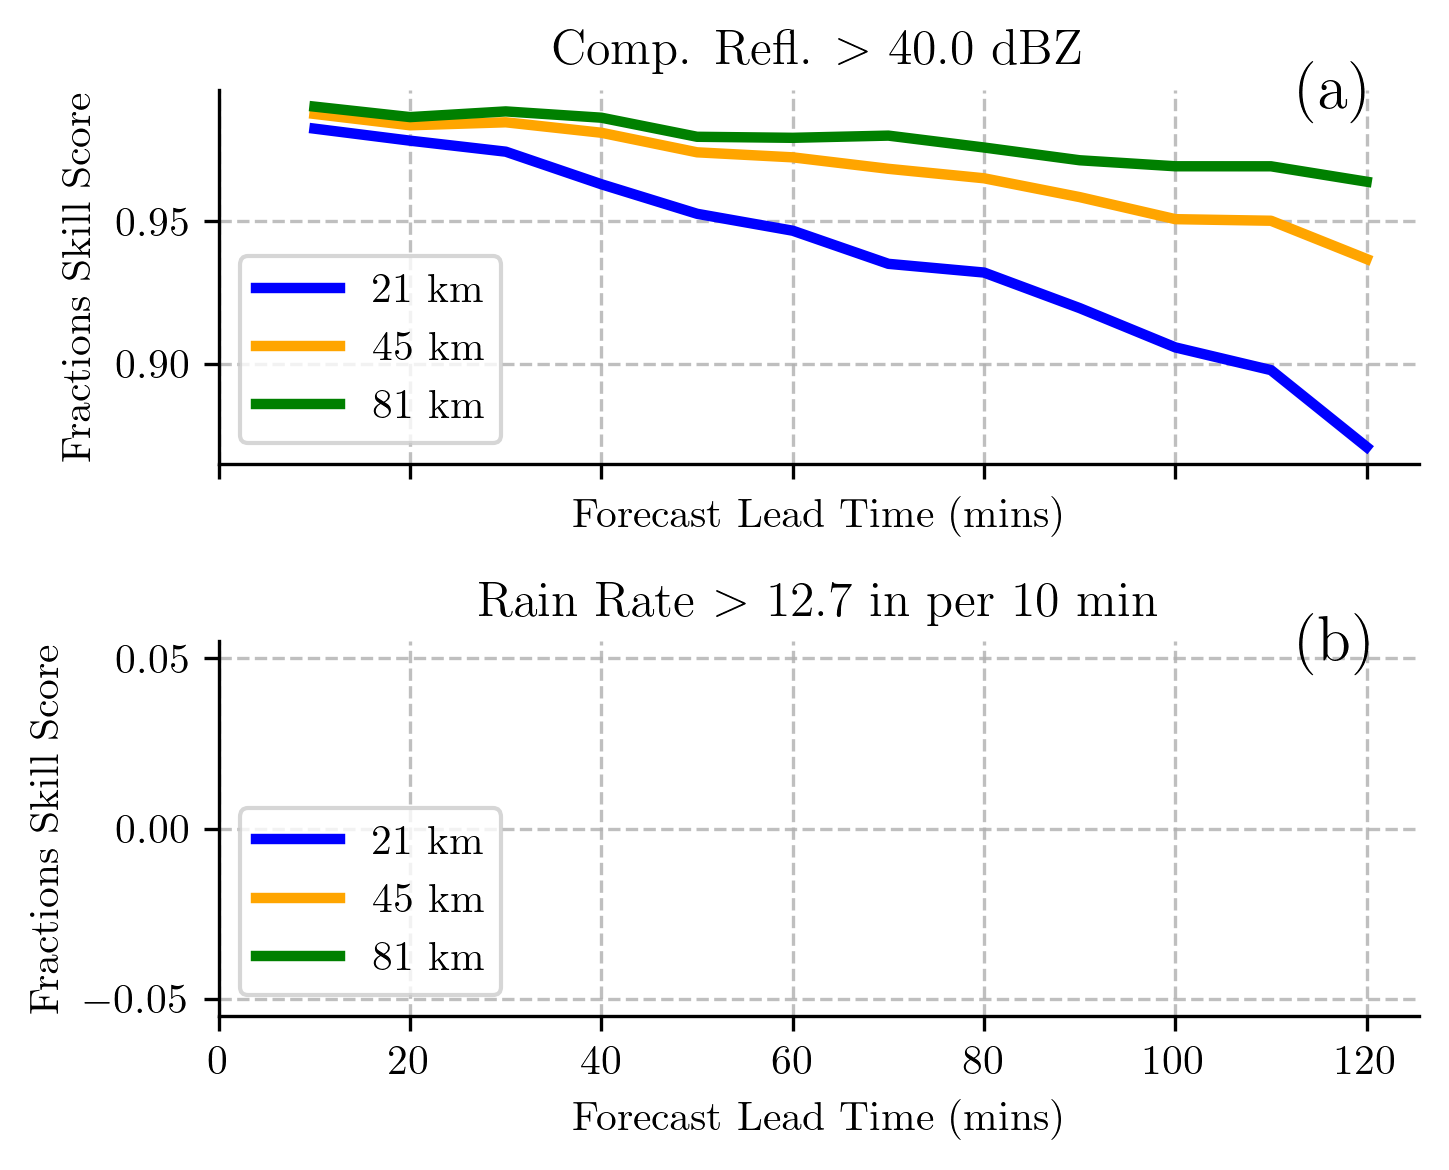

In [32]:
import ast
labels_dict = {'COMPOSITE_REFL_10CM' : 'Comp. Refl.', 
               'RAIN_AMOUNT' : 'Rain Rate'
              }

units_dict = {'COMPOSITE_REFL_10CM' : 'dBZ', 
               'RAIN_AMOUNT' : 'in per 10 min'
              }

fig, axes = plt.subplots(figsize=(5,4), dpi=300, ncols=1, nrows=2, sharex=True)

colors = ['blue', 'orange', 'green']
idx = 0 # Which dataset to plot for.

fss_vars = ['COMPOSITE_REFL_10CM', 'RAIN_AMOUNT']
fss_windows = datasets[idx].attrs['fss_windows']
# Convert the string stored in the netcdf back into a list of integers 
# and convert the fss_thresh_dict into an actual dict. 
fss_windows = [int(x) for x in fss_windows.strip('[]').split(', ')]
fss_thresh_dict = ast.literal_eval(datasets[idx].attrs['fss_thresh_dict'])


for i, (var, ax) in enumerate(zip(fss_vars, axes.flat)): 
    for w, window in enumerate(fss_windows):
        ax.plot(times, datasets[idx][f'{var}_fss'].isel(window=w), c=colors[w], lw=2.5, label=f'{3*window} km')
        ax.set_title(f'{labels_dict[var]} $>$ {fss_thresh_dict[var][0]:.1f} {units_dict[var]}')
        
        ax.set_xlabel('Forecast Lead Time (mins)')
        ax.set_ylabel('Fractions Skill Score')

    ax.legend(loc='lower left')
    ax.grid(ls='dashed', alpha=0.8)
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)
    
    ax.annotate(f'({lowercase_letters[i]})', xy=(0.9, 0.95), xycoords='axes fraction', fontsize=15)
    
plt.tight_layout()